# **Model Machine Learning Klasfikasi dan Rekomendasi Musik**
_Oleh :_
1. *M299R5310 - Muhammad Aldi Surya Putra*
2. *M014V6060 - Ayu Kadek Nadya Oktaviana*

## **1. Import Library**

In [1]:
!pip install opendatasets
# Usual Library
import pandas as pd
import numpy as np
import sklearn
import os
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Download Dataset
import opendatasets as od 

# Audio Library
import librosa

# Classification Library
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

## **2. Download Dataset**

In [2]:
# Download Dataset from Kaggle
od.download("https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification")
od.download("https://www.kaggle.com/sashankpillai/spotify-top-200-charts-20202021")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aldysp34
Your Kaggle Key: ··········


100%|██████████| 1.21G/1.21G [00:08<00:00, 159MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aldysp34
Your Kaggle Key: ··········


100%|██████████| 165k/165k [00:00<00:00, 44.7MB/s]

## **3. Dataset**

### **3.1 Dataset Audio untuk Klasifikasi**

In [3]:
# Read Dataset
audio_data = '/content/gtzan-dataset-music-genre-classification/Data/genres_original'
print('Genre :')
print(list(os.listdir(audio_data)))
print('\n')

metadata = pd.read_csv('/content/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv')
metadata.head()

Genre :
['reggae', 'metal', 'disco', 'country', 'hiphop', 'jazz', 'pop', 'classical', 'rock', 'blues']




,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


### **3.2 Dataset untuk Rekomendasi Musik**

In [4]:
# Read data untuk rekomendasi lagu
spotify_df = pd.read_csv("/content/spotify-top-200-charts-20202021/spotify_dataset.csv", encoding='mac_roman')
spotify_df.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",M√•neskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [5]:
print("*Jumlah kolom dan index*")
print(f"Index : {spotify_df.shape[0]}\n Kolom : {spotify_df.shape[1]}")
print("\n")
print("*Kolom pada dataframe*")
print(spotify_df.columns)
print("\n")
print("*Info pada kolom*")
print(spotify_df.info())
print("\n")
print("*Info dataframe*")
print(spotify_df.describe())

*Jumlah kolom dan index*
Index : 1556
 Kolom : 23


*Kolom pada dataframe*
Index(['Index', 'Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence',
       'Chord'],
      dtype='object')


*Info pada kolom*
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   St

In [6]:
# Cek data kosong
print(spotify_df.isnull().sum())

Index                        0
Highest Charting Position    0
Number of Times Charted      0
Week of Highest Charting     0
Song Name                    0
Streams                      0
Artist                       0
Artist Followers             0
Song ID                      0
Genre                        0
Release Date                 0
Weeks Charted                0
Popularity                   0
Danceability                 0
Energy                       0
Loudness                     0
Speechiness                  0
Acousticness                 0
Liveness                     0
Tempo                        0
Duration (ms)                0
Valence                      0
Chord                        0
dtype: int64


In [7]:
# Drop kolom yang tidak digunakan
spotify_df.drop(['Index', 'Highest Charting Position','Number of Times Charted','Week of Highest Charting','Streams','Artist Followers','Song ID','Weeks Charted','Popularity','Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Chord'], axis=1, inplace=True)

In [8]:
spotify_df

,Song Name,Artist,Genre,Release Date
0,Beggin',M√•neskin,"['indie rock italiano', 'italian pop']",2017-12-08
1,STAY (with Justin Bieber),The Kid LAROI,['australian hip hop'],2021-07-09
2,good 4 u,Olivia Rodrigo,['pop'],2021-05-21
3,Bad Habits,Ed Sheeran,"['pop', 'uk pop']",2021-06-25
4,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,"['lgbtq+ hip hop', 'pop rap']",2021-07-23
...,...,...,...,...
1551,New Rules,Dua Lipa,"['dance pop', 'pop', 'uk pop']",2017-06-02
1552,Cheirosa - Ao Vivo,Jorge & Mateus,"['sertanejo', 'sertanejo universitario']",2019-10-11
1553,Havana (feat. Young Thug),Camila Cabello,"['dance pop', 'electropop', 'pop', 'post-teen ...",2018-01-12
1554,Surtada - Remix Brega Funk,"Dad√° Bolad√£o, Tati Zaqui, OIK","['brega funk', 'funk carioca']",2019-09-25


## **4. Ekstraksi Fitur MFCC (Mel Frequency Cepstral Coefficients)**

In [9]:
def features(data):
  audio, sample_rate = librosa.load(data_name, res_type="kaiser_fast")
  mfccs_features = librosa.feature.mfcc(y = audio, sr=22050 , n_mfcc = 40) #36565
  mfccs_var = np.var(mfccs_features.T, axis=0)
  mfccs_mean = np.mean(mfccs_features.T, axis=0)
  mfcc = mfccs_var+mfccs_mean
  
  return mfcc

In [10]:
# Ekstraksi fitur MFCC untuk seluruh data audio

extracted_features=[]
for index_num, row in tqdm(metadata.iterrows()):
    try:
        final_class_labels = row["label"]
        data_name = os.path.join(os.path.abspath(audio_data), final_class_labels+'/', str(row["filename"]))    
        data = features(data_name)
        extracted_features.append([data, final_class_labels])
    except Exception as e:
        print(f"Error: {e}")
        continue

557it [01:13,  5.20it/s]

Error: 


1000it [01:53,  8.79it/s]


In [11]:
# Print hasil ekstraksi fitur
df = pd.DataFrame(extracted_features, columns=['feature','class'])
df.head()

,feature,class
0,"[2450.637, 417.4856, 216.4063, 193.47333, 161....",blues
1,"[7557.0537, 684.25116, 581.76605, 300.3838, 28...",blues
2,"[3228.3223, 649.21136, 382.6873, 175.77469, 14...",blues
3,"[5307.9727, 606.5962, 262.82385, 185.1264, 269...",blues
4,"[5034.9546, 980.0044, 298.20514, 215.60419, 30...",blues


In [12]:
# Hitung jumlah data per kelas
df['class'].value_counts()

hiphop       100
classical    100
metal        100
rock         100
reggae       100
disco        100
blues        100
pop          100
country      100
jazz          99
Name: class, dtype: int64

In [13]:
# Independent Dataset
# Ubah data dari list menjadi array

X = np.array(df['feature'].tolist())
y = np.array(df['class'].tolist())

In [14]:
print('X shape\t:', X.shape)
print('y shape\t:', y.shape)

X shape	: (999, 40)
y shape	: (999,)


## **5. Klasifikasi Genre**

### **5.1 Data Preparation**

#### **1. Encoding Label Genre**

In [15]:
# Melakukan pengkodean label dengan LabelEncoder()
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [16]:
print('y shape after encode label :', y.shape)

y shape after encode label : (999, 10)


#### **2. Splitting Data Train dan Test**

In [17]:
# Split train dan test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [18]:
print(f"X_train\t{X_train.shape}")
print(f"X_test\t{X_test.shape}")
print(f"y_train\t{y_train.shape}")
print(f"y_test\t{y_test.shape}")

X_train	(669, 40)
X_test	(330, 40)
y_train	(669, 10)
y_test	(330, 10)


### **5.2 Modeling Using Deep Learning**

In [19]:
# Model Build Deep Learning
model=Sequential()
model.add(Dense(1024, input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))

# Final Layer
model.add(Dense(10, activation='softmax'))  

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              41984     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [20]:
# Compile Model
model.compile(optimizer = "adam",
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [21]:
# Fit Model
history = model.fit(X_train, y_train,
                 validation_data = (X_test, y_test),
                 epochs = 800,
                 batch_size = 64)

Epoch 1/800
11/11 [==============================] - 2s 32ms/step - loss: 138.2680 - accuracy: 0.1106 - val_loss: 19.9634 - val_accuracy: 0.1303
Epoch 2/800
11/11 [==============================] - 0s 9ms/step - loss: 58.2600 - accuracy: 0.1196 - val_loss: 10.7396 - val_accuracy: 0.0697
Epoch 3/800
11/11 [==============================] - 0s 13ms/step - loss: 34.3319 - accuracy: 0.1136 - val_loss: 4.8975 - val_accuracy: 0.1424
Epoch 4/800
11/11 [==============================] - 0s 10ms/step - loss: 20.4320 - accuracy: 0.1121 - val_loss: 4.1333 - val_accuracy: 0.1727
Epoch 5/800
11/11 [==============================] - 0s 10ms/step - loss: 15.1021 - accuracy: 0.1241 - val_loss: 2.7747 - val_accuracy: 0.0909
Epoch 6/800
11/11 [==============================] - 0s 9ms/step - loss: 11.6132 - accuracy: 0.1315 - val_loss: 2.5820 - val_accuracy: 0.1394
Epoch 7/800
11/11 [==============================] - 0s 10ms/step - loss: 8.6371 - accuracy: 0.1031 - val_loss: 2.6055 - val_accuracy: 0.1879

Max. Validation Accuracy 0.5727272629737854


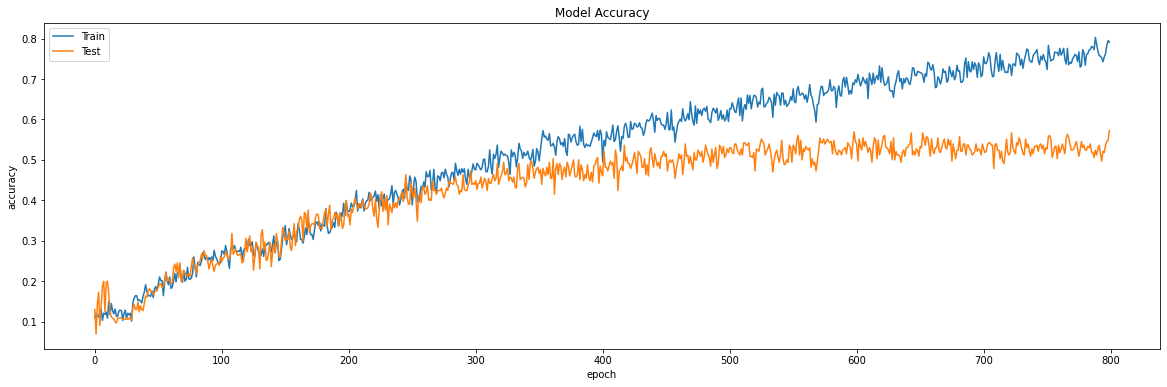

In [22]:
print("Max. Validation Accuracy", max(history.history["val_accuracy"]))

# Plot Akurasi
plt.figure(figsize=(20,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('plot_akurasi.png')
plt.show()

### **5.3 Model Evaluation**

In [23]:
# Model evaluasi
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)
print("Loss Test\t:", test_loss)
print("Accuracy Test\t:", test_acc*100)

3/3 [==============================] - 0s 7ms/step - loss: 1.9342 - accuracy: 0.5727
Loss Test	: 1.934204339981079
Accuracy Test	: 57.27272629737854


### **5.4 Testing Model**

In [24]:
# Model Predict
predictions = np.argmax(model.predict(X_test), axis=-1)
predictions

array([7, 0, 4, 9, 4, 5, 3, 8, 0, 9, 6, 2, 4, 8, 9, 9, 9, 3, 3, 3, 9, 4,
       0, 9, 1, 2, 0, 2, 3, 9, 6, 4, 3, 3, 7, 3, 0, 9, 8, 3, 9, 5, 6, 0,
       2, 8, 5, 9, 4, 8, 3, 6, 4, 2, 8, 8, 7, 7, 8, 5, 8, 6, 1, 0, 7, 8,
       5, 4, 3, 9, 3, 9, 9, 7, 7, 6, 6, 3, 6, 2, 6, 9, 6, 9, 8, 3, 5, 3,
       9, 7, 7, 8, 8, 5, 0, 3, 8, 8, 5, 9, 1, 5, 6, 6, 8, 0, 1, 8, 5, 4,
       2, 5, 3, 4, 9, 3, 9, 9, 3, 1, 3, 4, 8, 6, 3, 9, 2, 4, 6, 4, 2, 6,
       7, 6, 9, 9, 3, 1, 3, 2, 7, 4, 6, 3, 4, 4, 0, 2, 2, 5, 3, 9, 7, 8,
       8, 4, 9, 0, 8, 8, 5, 5, 1, 2, 9, 5, 8, 3, 1, 8, 5, 8, 3, 3, 3, 1,
       7, 6, 5, 3, 2, 6, 2, 4, 3, 3, 9, 3, 8, 8, 8, 6, 7, 8, 6, 1, 9, 3,
       3, 0, 6, 9, 3, 3, 6, 8, 1, 9, 5, 3, 8, 3, 1, 5, 0, 8, 6, 2, 6, 6,
       4, 6, 9, 0, 7, 5, 5, 2, 8, 4, 0, 3, 0, 1, 9, 9, 2, 2, 9, 6, 3, 2,
       4, 0, 9, 8, 9, 4, 9, 9, 8, 2, 3, 8, 8, 8, 0, 3, 7, 7, 5, 7, 5, 9,
       4, 4, 3, 3, 3, 3, 5, 9, 7, 3, 5, 5, 1, 6, 4, 7, 3, 7, 0, 5, 6, 0,
       4, 6, 2, 7, 3, 2, 5, 5, 9, 6, 8, 1, 0, 5, 7,

In [25]:
# Input path audio yang akan di test
filename = "/content/gtzan-dataset-music-genre-classification/Data/genres_original/country/country.00098.wav"

# Librosa load
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 

# MFCC Fitur Inputan Audio
mfccs_features = librosa.feature.mfcc(y = audio, sr = 22050, n_mfcc = 40)
mfccs_mean = np.mean(mfccs_features.T, axis=0)
mfccs_var = np.var(mfccs_features.T, axis=0)
mfccs_scaled_features = mfccs_mean+mfccs_var
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print('\n', mfccs_scaled_features.shape)

predicted = model.predict(mfccs_scaled_features)
predicted_label = np.argmax(predicted, axis=1)
print("Label Genre\t:", predicted_label)

if predicted_label == [[0]]:
  genre_detected = 'Blues'
elif predicted_label == [[1]]:
  genre_detected = 'Classical'
elif predicted_label == [[2]]:
  genre_detected = 'Country'
elif predicted_label == [[3]]:
  genre_detected = 'Disco'
elif predicted_label == [[4]]:
  genre_detected = 'Hip-hop'
elif predicted_label == [[5]]:
  genre_detected = 'Jazz'
elif predicted_label == [[6]]:
  genre_detected = 'Metal'
elif predicted_label == [[7]]:
  genre_detected = 'Pop'
elif predicted_label == [[8]]:
  genre_detected = 'Reggae'
else:
  genre_detected = 'Rock'

print("Prediksi Genre\t:", genre_detected)

[[1931.6051    719.40393   348.46298   260.1354    177.10098   168.79082
    95.76363   100.37739    59.452965  139.50424    71.950035   71.59687
    85.15747   110.351326   83.571      72.21319    74.44397    71.093216
    72.7251     60.01747    67.748695   90.94915    90.25532    76.39884
    63.689583   50.26074    84.84713   121.461494  118.296844   76.8911
   115.6932    162.5444     93.99151    98.65358   167.16077   109.46196
    57.311253   99.84236   182.80707   131.1651  ]]

 (1, 40)
Label Genre	: [2]
Prediksi Genre	: Country


## **6. Save Model**

In [26]:
# Save Model
model.save('model.h5')

## **7. Rekomendasi Lagu dari Genre**

In [27]:
# Inisialisasi genre hasil klasifikasi sebagai input untuk mendapatkan list lagu
label = genre_detected.lower() 
label

'country'

In [28]:
# Cari lagu
song = pd.DataFrame(spotify_df.loc[spotify_df['Genre'].str.contains(label)])

In [29]:
# Lihat list lagu yang dihasilkan
song

,Song Name,Artist,Genre,Release Date
182,Fancy Like,Walker Hayes,"['contemporary country', 'country', 'country r...",2021-06-04
230,Memory,"Kane Brown, blackbear","['contemporary country', 'country road']",2021-07-09
575,Wasted On You,Morgan Wallen,['contemporary country'],2021-01-08
579,Somebody‚Äôs Problem,Morgan Wallen,['contemporary country'],2020-11-20
595,Sand In My Boots,Morgan Wallen,['contemporary country'],2021-01-08
596,865,Morgan Wallen,['contemporary country'],2021-01-08
597,7 Summers,Morgan Wallen,['contemporary country'],2021-01-08
601,More Than My Hometown,Morgan Wallen,['contemporary country'],2021-01-08
602,Warning,Morgan Wallen,['contemporary country'],2021-01-08
659,"Baby, It's Cold Outside (feat. Meghan Trainor)",Brett Eldredge,"['contemporary country', 'country', 'country r...",2016-10-28
